## Example notebook for using Haversine distance instead of Euclidean distance in any stationary GPflow kernel.

Two main functions: \
haversine_distance(X1,X2) takes in [lat, lon] pairs for each X1 and X2 in degrees and calculated the haversine distance between all combinations of points. \
HaversineDistance(gpflow.Kernel()) takes in any stationary GPflow kernel and uses the above distance calculation instead of Euclidean distance. \
Below is also plots to visualize the difference between the 1D Euclidean version and the geospatial haversince version of a kernel. 

Maura Dewey, April 2024. \
Based on this stackoverflow: \
https://stackoverflow.com/questions/59512401/custom-haversine-matern52-kernel-in-gpflow-2-0

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import gpflow
import tensorflow as tf

In [48]:
#haversine functions:

def haversine_dist(X, X2):
    """
    Calculate the great-circle distance between two points on the Earth's surface.
    d = 2 * R * asin(sqrt(sin(Δlat/2)**2 + cose(lat1)*cos(lat2)*sin(Δlon/2)**2))    
    where:
    R is the earth's radius, 6371 km and Δlat and Δlon are the differences in latitude and longitude.
    Assumes 2D inputs, with columns [lat, lon] in degrees.
    """
    pi = np.pi / 180
    f = tf.expand_dims(X * pi, -2)  # ... x N x 1 x D
    f2 = tf.expand_dims(X2 * pi, -3)  # ... x 1 x M x D
    d = tf.sin((f - f2) / 2) ** 2
    lat1, lat2 = tf.expand_dims(X[:, 0] * pi, -1), \
                 tf.expand_dims(X2[:, 0] * pi, -2)
    cos_prod = tf.cos(lat2) * tf.cos(lat1)
    a = d[:,:,0] + cos_prod * d[:,:,1]
    c = tf.asin(tf.sqrt(a)) * 6371 * 2
    return c


class HaversineDistance(gpflow.kernels.Stationary):
    """
    Wrapper to use the haversine distance with any stationary kernel in GPflow.
    
    """
    def __init__(self, base: gpflow.kernels.Stationary):
        self.base = base

    @property
    def active_dims(self):
        return self.base.active_dims
    
    @property
    def variance(self):
        return self.base.variance
    
    def K(self, X, X2=None):
        if X2 is None:
            X2 = X
        r = haversine_dist(X, X2) / self.base.lengthscales

        if hasattr(self.base, 'K_r'):
            return self.base.K_r(r)
        else:
            return self.base.K_r2(tf.square(r))



In [62]:
#plotting functions:

#plot regular kernel:
def plotkernelsample(k, ax, xmin=-3, xmax=3):
    xx = np.linspace(xmin, xmax, 100)[:, None]
    K = k(xx)
    ax.plot(xx, np.random.multivariate_normal(np.zeros(100), K, 3).T)
    ax.set_title(k.__class__.__name__)

#plot haversine version:
def plothaversinekernel(k, ax):
    X = np.concatenate([np.random.uniform(-90,90,1000)[:,None],np.random.uniform(-180,180,1000)[:,None]],axis=1)
    K = k(X)
    zdata=np.random.multivariate_normal(np.zeros(1000), K, 1).T

    #create grid for plotting contours of zdata:
    lat = np.linspace(-90,90,100)
    lon = np.linspace(-180,180,100)
    lon, lat = np.meshgrid(lon, lat)

    #scipy linearly interpolate zdata to grid:
    from scipy.interpolate import griddata
    grid_z0 = griddata((X[:,1],X[:,0]), zdata.flatten(), (lon, lat), method='linear')

    #plot:
    c=ax.contourf(lon,lat,grid_z0,levels=20)
    plt.gca().coastlines()
    #ax.scatter(X[:,1],X[:,0], c='k')
    #ax.scatter3D(X[:,1],X[:,0], zdata, c=zdata)
    ax.set_title(k.__class__.__name__ + ', lengthscale=' + np.array2string(k.base.__dict__['lengthscales'].numpy()) + ' km')
    plt.colorbar(c,orientation='horizontal')


def plotkernelcomparision(test_kernel, lngscls):
    #setup figure:
    fig = plt.figure(figsize=(16, 6))
    ax1 = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2, projection=ccrs.PlateCarree())
    #plot:
    plotkernelsample(test_kernel(lengthscales=lngscls[0]), ax1)
    plothaversinekernel(HaversineDistance(test_kernel(lengthscales=lngscls[1])), ax2)
#NOTE that setting the lengthscales for the Haversine kernel is important!!!


C:\Users\made2928\AppData\Local\Temp\ipykernel_8340\630230952.py:14: RuntimeWarning: covariance is not positive-semidefinite.
  zdata=np.random.multivariate_normal(np.zeros(1000), K, 1).T


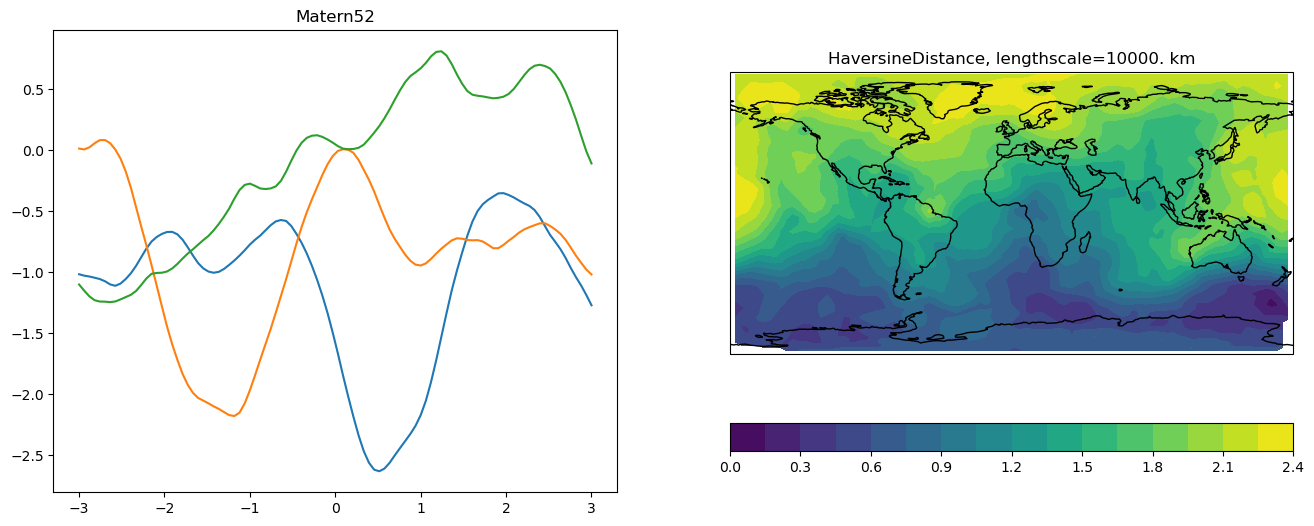

In [63]:
#NOTE that setting the lengthscales for the Haversine kernel is important!!!
plotkernelcomparision(gpflow.kernels.Matern52, [1.0, 10000.0])

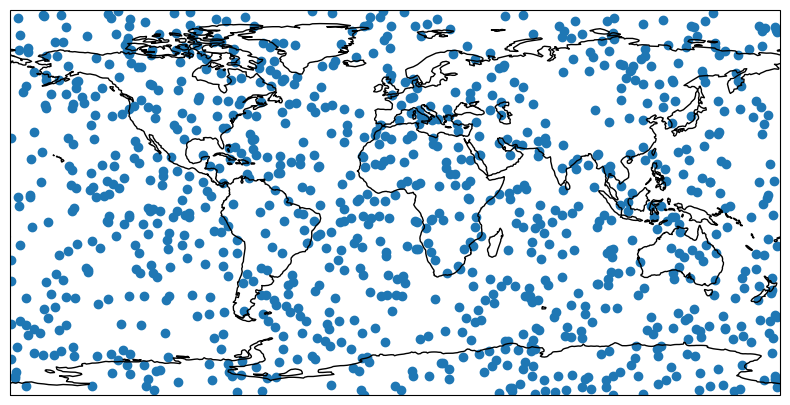

In [43]:
#scatter plot map of example lat/lon points where kernel is sampled:
X = np.concatenate([np.random.uniform(-90,90,1000)[:,None],np.random.uniform(-180,180,1000)[:,None]],axis=1)
fig=plt.figure(figsize=(10, 5))
fig.add_subplot(111, projection=ccrs.PlateCarree())
plt.scatter(X[:,1],X[:,0])
plt.gca().coastlines()
